# Divisão e conquista
A abordagem de **divisão e conquista** resolve o problema do ponto mais próximo em **tempo O(n log n)**, muito melhor do que o O(n²) da força bruta.

Ela se baseia em três passos clássicos:

1. **Dividir**: divide os pontos pela coordenada `x` em dois subconjuntos aproximadamente iguais.
2. **Conquistar**: resolve o problema recursivamente em cada subconjunto.
3. **Combinar**: verifica se há um par de pontos mais próximo que cruza a linha de divisão (região central).


# Explicação detalhada

**✂️ Como funciona passo a passo:**

1. **Ordenação inicial**

* Ordena os pontos pelo eixo `x` (**Px**) e também mantém uma ordenação por `y` (**Py**) — ambas serão úteis.

2. **Divisão**

* Divide os pontos em dois grupos:

  * Esquerda: pontos à esquerda da linha média
  * Direita: pontos à direita
* A linha de divisão está no ponto médio de `Px`.

3. **Recursão**

* Aplica a função recursivamente para os dois lados.
* Obtém a menor distância `d` dos dois lados (esquerda e direita).

4. **Combinação — Verificação na faixa central**

* Cria um **“strip”** com os pontos da lista **Py** que estão a **menos de `d` de distância da linha de divisão (eixo vertical)**.
* Compara **somente os pontos próximos no strip** (até no máximo 7 pontos à frente no eixo `y`).

**📐 Intuição geométrica**

* A chave da eficiência está no fato de que, **numa faixa central estreita**, só precisamos verificar **um número constante de pontos vizinhos**.
* Isso reduz o número de comparações significativamente.

**⚙️ Resumo dos passos**

1. Ordene os pontos por `x` e `y` (O(n log n))
2. Divida os pontos
3. Recursivamente resolva esquerda e direita
4. Calcule a menor distância entre os dois lados
5. Cheque a faixa central com no máximo 7 comparações por ponto
6. Retorne a menor distância entre as três regiões

**🧮 Complexidade**

* Cada nível da recursão divide em 2 partes → **log n** níveis
* Em cada nível, o trabalho para combinar é **O(n)**
* Logo:

  $$
  T(n) = 2T(n/2) + O(n) \Rightarrow O(n \log n)
  $$

# Implementação

## Código base

In [2]:
import time
from typing import List, Tuple
from math import inf
from src.model.ponto import Ponto

def ponto_mais_proximo_divisao_conquista(pontos: List['Ponto']) -> dict:
    """
    Encontra o par de pontos mais próximos usando divisão e conquista.

    Retorna:
        {
            "ponto1": Ponto,
            "ponto2": Ponto,
            "distancia": float,
            "tempo": float
        }
    """

    def distancia(p1: Ponto, p2: Ponto) -> float:
        return ((p1.x - p2.x)**2 + (p1.y - p2.y)**2)**0.5

    def solucao_forca_bruta(pontos: List[Ponto]) -> Tuple[Ponto, Ponto, float]:
        min_dist = inf
        ponto1 = ponto2 = None
        for i in range(len(pontos)):
            for j in range(i + 1, len(pontos)):
                d = distancia(pontos[i], pontos[j])
                if d < min_dist:
                    min_dist = d
                    ponto1, ponto2 = pontos[i], pontos[j]
        return ponto1, ponto2, min_dist # type: ignore

    def strip_mais_proximo(strip: List[Ponto], d_min: float) -> Tuple[Ponto, Ponto, float]:
        min_dist = d_min
        p1 = p2 = None
        for i in range(len(strip)):
            for j in range(i + 1, len(strip)):
                if (strip[j].y - strip[i].y) >= min_dist:
                    break
                d = distancia(strip[i], strip[j])
                if d < min_dist:
                    min_dist = d
                    p1, p2 = strip[i], strip[j]
        return p1, p2, min_dist # type: ignore

    def recursivo(px: List[Ponto], py: List[Ponto]) -> Tuple[Ponto, Ponto, float]:
        n = len(px)
        if n <= 3:
            return solucao_forca_bruta(px)

        mid = n // 2
        ponto_medio = px[mid]

        Qx = px[:mid]
        Rx = px[mid:]
        Qy = list(filter(lambda p: p.x <= ponto_medio.x, py))
        Ry = list(filter(lambda p: p.x > ponto_medio.x, py))

        p1_esq, p2_esq, d_esq = recursivo(Qx, Qy)
        p1_dir, p2_dir, d_dir = recursivo(Rx, Ry)

        if d_esq < d_dir:
            d_min = d_esq
            p1, p2 = p1_esq, p2_esq
        else:
            d_min = d_dir
            p1, p2 = p1_dir, p2_dir

        strip = [p for p in py if abs(p.x - ponto_medio.x) < d_min]
        p3, p4, d_strip = strip_mais_proximo(strip, d_min)

        if d_strip < d_min:
            return p3, p4, d_strip
        else:
            return p1, p2, d_min

    # 🚀 Execução
    tempo_inicio = time.perf_counter()

    px = sorted(pontos, key=lambda p: p.x)
    py = sorted(pontos, key=lambda p: p.y)
    ponto1, ponto2, menor_distancia = recursivo(px, py)

    tempo_fim = time.perf_counter()

    return {
        "ponto1": ponto1,
        "ponto2": ponto2,
        "distancia": menor_distancia,
        "tempo": tempo_fim - tempo_inicio
    }


# Benchmark

## Função de teste

In [3]:
import matplotlib.pyplot as plt

from src.utils import gerar_pontos

def testar_tempos_divisao_conquista(n_inicial: int, n_final: int, passo: int, limite: int = 1000):
    """
    Testa o tempo de execução da função de divisão e conquista para diferentes tamanhos de entrada.

    Parameters
    ----------
    n_inicial : int
        Número inicial de pontos.
    n_final : int
        Número final de pontos.
    passo : int
        Incremento de pontos por teste.
    limite : int
        Valor máximo para coordenadas dos pontos.
    """
    tamanhos = []
    tempos = []

    for n in range(n_inicial, n_final + 1, passo):
        pontos = gerar_pontos(n, limite=limite)
        resultado = ponto_mais_proximo_divisao_conquista(pontos)
        
        tamanhos.append(n)
        tempos.append(resultado['tempo'])
        
        print(f"n = {n}, tempo = {resultado['tempo']:.6f} s")

    # Plotar
    plt.figure(figsize=(10, 6))
    plt.plot(tamanhos, tempos, marker='o', linestyle='-', color='darkgreen')
    plt.title('Tempo de Execução vs Número de Pontos (Divisão e Conquista)')
    plt.xlabel('Número de pontos')
    plt.ylabel('Tempo de execução (s)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Resultados

n = 0, tempo = 0.000004 s
n = 100, tempo = 0.000231 s
n = 200, tempo = 0.000448 s
n = 300, tempo = 0.000730 s
n = 400, tempo = 0.000954 s
n = 500, tempo = 0.001575 s
n = 600, tempo = 0.001503 s
n = 700, tempo = 0.002431 s
n = 800, tempo = 0.002023 s
n = 900, tempo = 0.002406 s
n = 1000, tempo = 0.002738 s
n = 1100, tempo = 0.003083 s
n = 1200, tempo = 0.003322 s
n = 1300, tempo = 0.003620 s
n = 1400, tempo = 0.003716 s
n = 1500, tempo = 0.003882 s
n = 1600, tempo = 0.004336 s
n = 1700, tempo = 0.004652 s
n = 1800, tempo = 0.005059 s
n = 1900, tempo = 0.005639 s
n = 2000, tempo = 0.005848 s
n = 2100, tempo = 0.006437 s
n = 2200, tempo = 0.007009 s
n = 2300, tempo = 0.007050 s
n = 2400, tempo = 0.006903 s
n = 2500, tempo = 0.007438 s
n = 2600, tempo = 0.007446 s
n = 2700, tempo = 0.008069 s
n = 2800, tempo = 0.008010 s
n = 2900, tempo = 0.008161 s
n = 3000, tempo = 0.008719 s
n = 3100, tempo = 0.008790 s
n = 3200, tempo = 0.009183 s
n = 3300, tempo = 0.011050 s
n = 3400, tempo = 0.013090

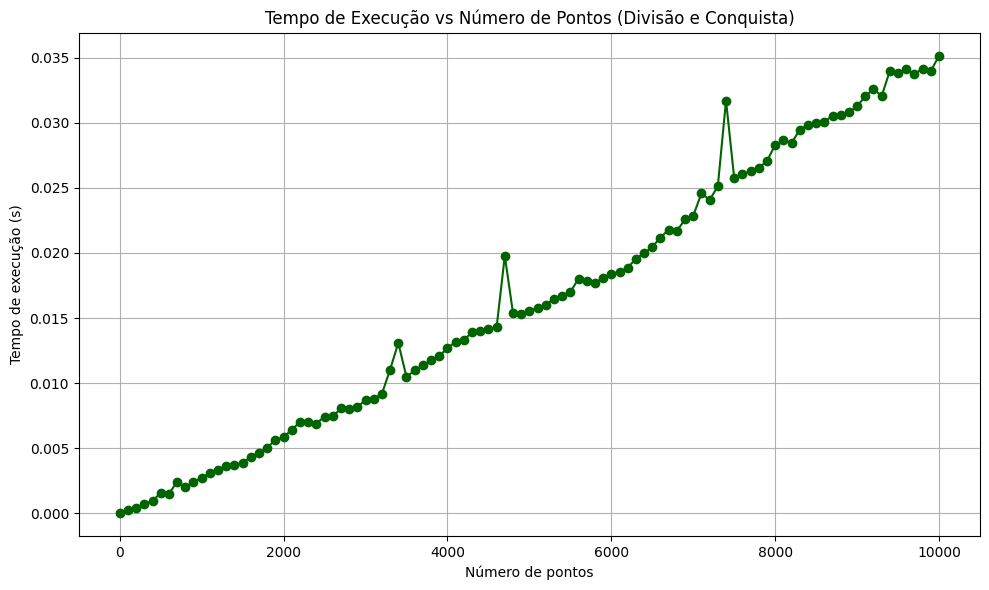

In [4]:
testar_tempos_divisao_conquista(n_inicial=0, n_final=10000, passo=100,limite=10000)